Objective: 
- To flag bad loans with a high default rate
- To chart different rates of approval and list the corresponding default risk for each


In [110]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

# Qs
- What are some characteristics of the loans that are classified as bad?
- Ways to ensure my model isn't discriminating based on some demographic details - should I not include those variables in my model?
- Need to check who are categorized as bad loanees to ensure it isn't predominantly people belonging to one group
- What are some feature eng that I can do?
    - Bucketize fields
    - create dummy flags 
    

In [2]:
# Read in the data

df_loans = pd.read_csv('./data/mokka_loan_flag.csv', na_values=)

df_loans.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [7]:
df_loans.shape

(4157, 22)

In [54]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   loanKey                         4157 non-null   int64         
 1   rep_loan_date                   4157 non-null   datetime64[ns]
 2   first_loan                      4157 non-null   datetime64[ns]
 3   dpd_5_cnt                       675 non-null    float64       
 4   dpd_15_cnt                      675 non-null    float64       
 5   dpd_30_cnt                      675 non-null    float64       
 6   first_overdue_date              675 non-null    datetime64[ns]
 7   close_loans_cnt                 4142 non-null   float64       
 8   federal_district_nm             4146 non-null   object        
 9   TraderKey                       4157 non-null   int64         
 10  payment_type_0                  4157 non-null   int64         
 11  paym

In [6]:
# NULL Value check

df_loans.isnull().sum()

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64

## Exploratory Analysis

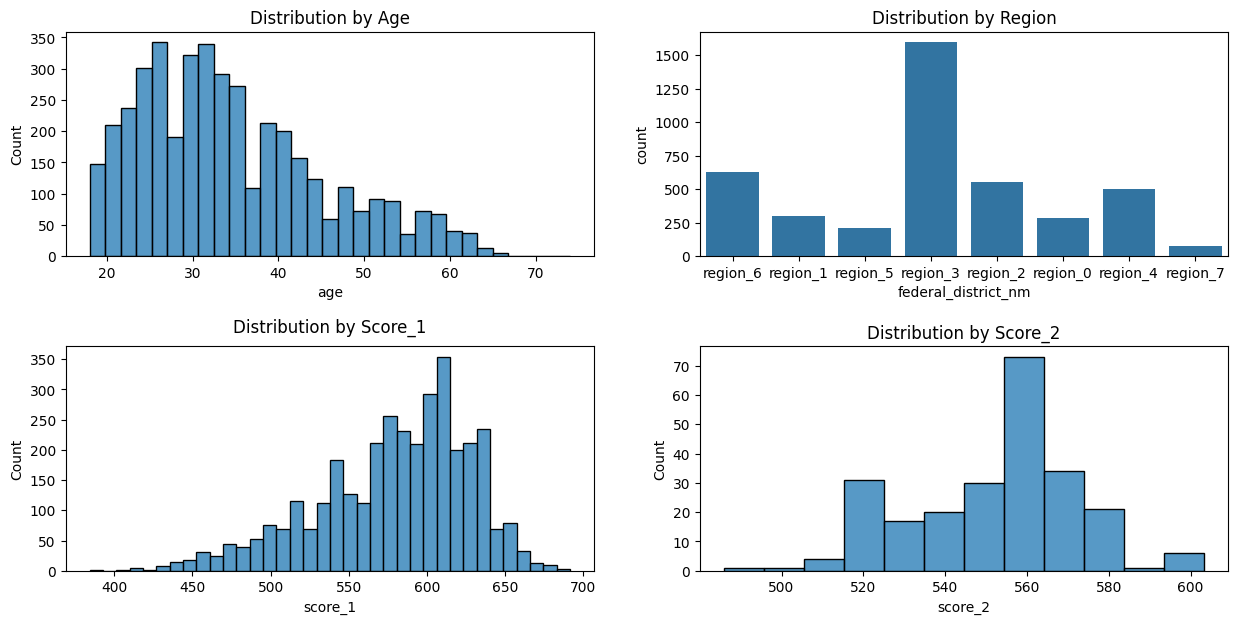

In [22]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
plt.subplots_adjust(hspace=0.4)

sns.histplot(data=df_loans, x='age', ax=axis[0,0])
sns.countplot(data=df_loans, x='federal_district_nm', ax=axis[0,1])
sns.histplot(data=df_loans, x='score_1', ax=axis[1,0])
sns.histplot(data=df_loans, x='score_2', ax=axis[1,1])

axis[0,0].set_title('Distribution by Age')
axis[0,1].set_title('Distribution by Region')
axis[1,0].set_title('Distribution by Score_1', pad=10)
axis[1,1].set_title('Distribution by Score_2')

plt.show()

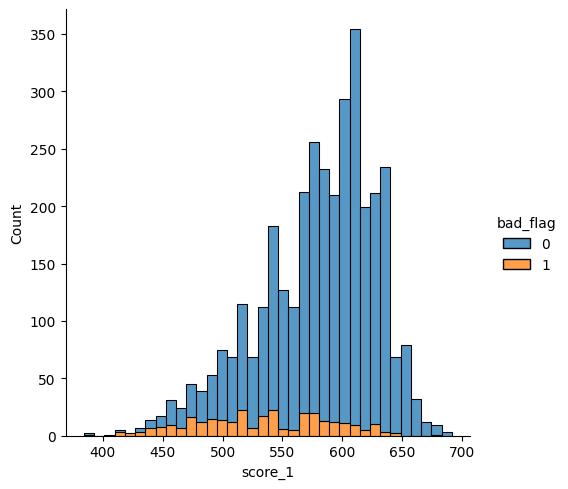

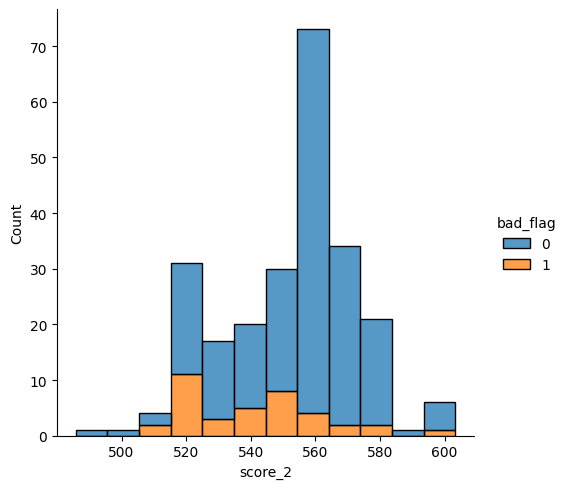

In [65]:
sns.displot(data=df_loans, x='score_1', hue='bad_flag', multiple='stack')
sns.displot(data=df_loans, x='score_2', hue='bad_flag', multiple='stack')

plt.show()

#### Observations
- A majority (~ >50) seem to be between the 20 - 35 age bracket
- A disproportionately large number of the loans seems to be coming from region 3
- Going by score 1, the major chunk of the loans are offered to those within the 550 - 650 bracket

#### Notes for Downstream processing
- The age and score fields could be bucketized 


In [25]:
# Number of bad loans vs good ones

df_loans['bad_flag'].value_counts()

bad_flag
0    3740
1     417
Name: count, dtype: int64

Very little number of bad loans compared to good ones, need to handle the imbalance between these counts

### Feature Engineering

In [115]:
# Duration between the first loan date and the reported loan date

df_loans['rep_loan_date'] = pd.to_datetime(df_loans['rep_loan_date'])
df_loans['first_loan'] = pd.to_datetime(df_loans['first_loan'])
df_loans['duration_since_first_loan'] = (df_loans['rep_loan_date'] - df_loans['first_loan']).dt.days


# Bucketing Age groups
def age_brackets(age):
    if age < 20:
        age = '<20'
    elif (age >=20 and age <= 25):
        age = '20-25'
    elif (age >=26 and age <= 30):
        age = '26-30'
    elif (age >=31 and age <= 35):
        age = '31-35'
    elif (age >=36 and age <= 40):
        age = '36-40'
    elif (age >=41 and age <= 45):
        age = '41-45'
    elif (age >=46 and age <= 50):
        age = '46-50'
    elif age > 50:
        age = '50+'
    
    return age

df_loans['age_groups'] = df_loans['age'].apply(lambda x: age_brackets(x) if pd.isna(x)==False else np.nan)


# Bucketing scores
def score_brackets(score, score_type:str):
    score = np.round(score,0)
    if score < 500:
        score = f'{score_type}_<500'
    elif (score >=500 and score <= 550):
        score = f'{score_type}_20-25'
    elif (score >=551 and score <= 600):
        score = f'{score_type}_551-600'
    elif (score >=601 and score <= 650):
        score = f'{score_type}_601-650'
    elif score > 651:
        score = f'{score_type}_651'
    
    return score

df_loans['score_1_brackets'] = df_loans['score_1'].apply(lambda x: score_brackets(x, score_type='score1') if pd.isna(x)==False else np.nan)
df_loans['score_2_brackets'] = df_loans['score_2'].apply(lambda x: score_brackets(x, score_type='score2') if pd.isna(x)==False else np.nan)

df_loans.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,score_2,age,gender,bad_flag,duration_since_first_loan,age_groups,score_1_brackets,score_2_brackets,first_loan_to_overdue_duration,days_since_first_overdue
0,708382,2016-10-06,2015-11-13,0.0,0.0,0.0,0,3.0,region_6,6,...,0.0,21.0,False,0,328,20-25,score1_<500,score2_<500,0.0,0.0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30 00:00:00,0.0,region_6,6,...,0.0,20.0,False,0,180,20-25,score1_<500,score2_<500,124.0,56.0
2,779736,2016-10-30,2015-12-21,0.0,0.0,0.0,0,2.0,region_1,6,...,0.0,19.0,False,0,314,<20,score1_<500,score2_<500,0.0,0.0
3,556376,2016-06-29,2015-06-30,0.0,0.0,0.0,0,1.0,region_6,14,...,0.0,21.0,False,0,365,20-25,score1_<500,score2_<500,0.0,0.0
4,266968,2015-12-01,2015-08-03,0.0,0.0,0.0,0,0.0,region_5,22,...,0.0,33.0,False,0,120,31-35,score1_<500,score2_<500,0.0,0.0


In [116]:
df_loans['first_overdue_date'] = pd.to_datetime(df_loans['first_overdue_date'])

df_loans['first_loan_to_overdue_duration'] = df_loans.apply(lambda x: (x['first_overdue_date'] - x['first_loan']).days if not pd.isna(x['first_overdue_date']) else np.nan, axis = 1)

df_loans['days_since_first_overdue'] = df_loans.apply(lambda x: (x['rep_loan_date'] - x['first_overdue_date']).days if not pd.isna(x['first_overdue_date']) else np.nan, axis = 1)


df_loans.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,score_2,age,gender,bad_flag,duration_since_first_loan,age_groups,score_1_brackets,score_2_brackets,first_loan_to_overdue_duration,days_since_first_overdue
0,708382,2016-10-06,2015-11-13,0.0,0.0,0.0,1970-01-01,3.0,region_6,6,...,0.0,21.0,False,0,328,20-25,score1_<500,score2_<500,-16752,17080
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,0.0,20.0,False,0,180,20-25,score1_<500,score2_<500,124,56
2,779736,2016-10-30,2015-12-21,0.0,0.0,0.0,1970-01-01,2.0,region_1,6,...,0.0,19.0,False,0,314,<20,score1_<500,score2_<500,-16790,17104
3,556376,2016-06-29,2015-06-30,0.0,0.0,0.0,1970-01-01,1.0,region_6,14,...,0.0,21.0,False,0,365,20-25,score1_<500,score2_<500,-16616,16981
4,266968,2015-12-01,2015-08-03,0.0,0.0,0.0,1970-01-01,0.0,region_5,22,...,0.0,33.0,False,0,120,31-35,score1_<500,score2_<500,-16650,16770


## Model Selection

In [117]:
classifiers = [
    SGDClassifier(max_iter=500, tol=1e-3, random_state=2),
    KNeighborsClassifier(),
    LogisticRegression(solver="lbfgs", random_state=2),
    LogisticRegressionCV(cv=5, random_state=2),
    BaggingClassifier(random_state=2),
    ExtraTreesClassifier(n_estimators=500, random_state=2),
    RandomForestClassifier(n_estimators=500, random_state=2),
    GaussianNB()
]

In [118]:
feature_cols = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt','federal_district_nm','payment_type_0','payment_type_1','payment_type_2','payment_type_3',
                'payment_type_4','payment_type_5','duration_since_first_loan','age_groups','score_1_brackets','score_2_brackets','first_loan_to_overdue_duration','days_since_first_overdue']

df_loans_no_nulls = df_loans.fillna(value=0)


df_loans_x = df_loans_no_nulls[feature_cols]

df_loans_y = df_loans_no_nulls['bad_flag']

df_loans_x = pd.get_dummies(data=df_loans_x, columns=['age_groups','score_1_brackets','score_2_brackets','federal_district_nm'],prefix='is', dtype='int')

df_loans_x.head()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,...,is_score2_<500,is_0,is_region_0,is_region_1,is_region_2,is_region_3,is_region_4,is_region_5,is_region_6,is_region_7
0,0.0,0.0,0.0,3.0,0,0,10,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1.0,0.0,0.0,0.0,0,0,6,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,2.0,0,0,0,5,0,0,...,1,0,0,1,0,0,0,0,0,0
3,0.0,0.0,0.0,1.0,0,0,4,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0.0,0,3,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [119]:
df_loans_x.columns

Index(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt',
       'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'payment_type_5', 'duration_since_first_loan',
       'first_loan_to_overdue_duration', 'days_since_first_overdue',
       'is_20-25', 'is_26-30', 'is_31-35', 'is_36-40', 'is_41-45', 'is_46-50',
       'is_50+', 'is_<20', 'is_651.0', 'is_score1_20-25', 'is_score1_551-600',
       'is_score1_601-650', 'is_score1_651', 'is_score1_<500',
       'is_score2_20-25', 'is_score2_551-600', 'is_score2_601-650',
       'is_score2_<500', 'is_0', 'is_region_0', 'is_region_1', 'is_region_2',
       'is_region_3', 'is_region_4', 'is_region_5', 'is_region_6',
       'is_region_7'],
      dtype='object')

In [120]:
# Evaluating models using cross val score

all_scores = []

for classifier in classifiers:

    

    score = cross_val_score(estimator=classifier, X=df_loans_x, y=df_loans_y, cv = 5, scoring='f1')
    all_scores.append( {
        'model_name': classifier.__class__.__name__,
        'f1 score': score.mean()
    })

df_model_scores = pd.DataFrame(all_scores)

df_model_scores


/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

,model_name,f1 score
0,SGDClassifier,0.057153
1,KNeighborsClassifier,0.051976
2,LogisticRegression,0.100824
3,LogisticRegressionCV,0.078650
4,BaggingClassifier,0.165895
5,ExtraTreesClassifier,0.217855
6,RandomForestClassifier,0.138448
7,GaussianNB,0.291847


In [87]:
df_loans_x.columns = [col.replace(' ','') for col in df_loans_x.columns]

rf_model = RandomForestClassifier(n_estimators=500, max_depth=5, n_jobs=-1, random_state=2)

scores = cross_val_score(estimator=rf_model, X=df_loans_x, y=df_loans_y, scoring='accuracy', cv=5)

print(f'Accuracy: {scores.mean()}')

Accuracy: 0.9001686452837175


In [98]:
df_loans_x.columns

Index(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt',
       'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'payment_type_5', 'duration_since_first_loan',
       'first_loan_to_overdue_duration', 'days_since_first_overdue',
       'is_20-25', 'is_26-30', 'is_31-35', 'is_36-40', 'is_41-45', 'is_46-50',
       'is_50+', 'is_<20', 'is_0', 'is_651.0', 'is_20-25', 'is_551-600',
       'is_601-650', 'is_651', 'is_<500', 'is_0', 'is_20-25', 'is_551-600',
       'is_601-650', 'is_<500', 'is_0', 'is_region_0', 'is_region_1',
       'is_region_2', 'is_region_3', 'is_region_4', 'is_region_5',
       'is_region_6', 'is_region_7'],
      dtype='object')

In [122]:
# Trying another time scaling the inputs

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

cols_to_scale = ['dpd_5_cnt','dpd_15_cnt','dpd_30_cnt','close_loans_cnt','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','payment_type_5','duration_since_first_loan',
                 'first_loan_to_overdue_duration','days_since_first_overdue']
pass_through_cols = [col for col in df_loans_x.columns if col not in cols_to_scale]

# Create a ColumnTransformer to scale selected columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale),
        ('cat', 'passthrough', pass_through_cols)
    ])


all_scores = []

for classifier in classifiers:
    # Create a pipeline that includes the preprocessor and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    score = cross_val_score(estimator=pipeline, X=df_loans_x, y=df_loans_y, cv = 5, scoring='f1')
    all_scores.append( {
        'model_name': classifier.__class__.__name__,
        'f1 score': score.mean()
    })

df_model_scores = pd.DataFrame(all_scores)

df_model_scores

,model_name,f1 score
0,SGDClassifier,0.070133
1,KNeighborsClassifier,0.172875
2,LogisticRegression,0.116572
3,LogisticRegressionCV,0.081561
4,BaggingClassifier,0.165522
5,ExtraTreesClassifier,0.217855
6,RandomForestClassifier,0.138248
7,GaussianNB,0.230006


In [114]:
df_loans_x.columns

Index(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt',
       'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'payment_type_5', 'duration_since_first_loan',
       'first_loan_to_overdue_duration', 'days_since_first_overdue',
       'is_20 - 25', 'is_26 - 30', 'is_31 - 35', 'is_36 - 40', 'is_41 - 45',
       'is_46 - 50', 'is_50+', 'is_<20', 'is_0', 'is_651.0', 'is_20 - 25',
       'is_551 - 600', 'is_601 - 650', 'is_651', 'is_<500', 'is_0',
       'is_20 - 25', 'is_551 - 600', 'is_601 - 650', 'is_<500', 'is_0',
       'is_region_0', 'is_region_1', 'is_region_2', 'is_region_3',
       'is_region_4', 'is_region_5', 'is_region_6', 'is_region_7'],
      dtype='object')

## Fixing Class Imbalance

### Downsampling the majority class

In [124]:
# Doensampling majority class

print(f"Prior to fixing class imbalance: {df_loans['bad_flag'].value_counts()}")

pos_class = df_loans[df_loans['bad_flag']==1]

neg_class = df_loans[df_loans['bad_flag']==0].sample(frac=0.2,random_state=2)

df_loans_balanced = pd.concat([pos_class, neg_class], axis=0)


print(f"Prior to fixing class imbalance: {df_loans_balanced['bad_flag'].value_counts()}")


Prior to fixing class imbalance: bad_flag
0    3740
1     417
Name: count, dtype: int64
Prior to fixing class imbalance: bad_flag
0    748
1    417
Name: count, dtype: int64


In [125]:
feature_cols = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt','federal_district_nm','payment_type_0','payment_type_1','payment_type_2','payment_type_3',
                'payment_type_4','payment_type_5','duration_since_first_loan','age_groups','score_1_brackets','score_2_brackets','first_loan_to_overdue_duration','days_since_first_overdue']

df_loans_no_nulls = df_loans_balanced.fillna(value=0)


df_loans_x_no_nulls = df_loans_no_nulls[feature_cols]

df_loans_y = df_loans_no_nulls['bad_flag']

df_loans_x = pd.get_dummies(data=df_loans_x_no_nulls, columns=['age_groups','score_1_brackets','score_2_brackets','federal_district_nm'],prefix='is', dtype='int')


cols_to_scale = ['dpd_5_cnt','dpd_15_cnt','dpd_30_cnt','close_loans_cnt','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','payment_type_5','duration_since_first_loan',
                 'first_loan_to_overdue_duration','days_since_first_overdue']

pass_through_cols = [col for col in df_loans_x.columns if col not in cols_to_scale]

# Create a ColumnTransformer to scale selected columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale),
        ('cat', 'passthrough', pass_through_cols)
    ])


all_scores = []

for classifier in classifiers:
    # Create a pipeline that includes the preprocessor and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    score = cross_val_score(estimator=pipeline, X=df_loans_x, y=df_loans_y, cv = 5, scoring='f1')
    all_scores.append( {
        'model_name': classifier.__class__.__name__,
        'f1 score': score.mean()
    })

df_model_scores = pd.DataFrame(all_scores)

df_model_scores

,model_name,f1 score
0,SGDClassifier,0.534581
1,KNeighborsClassifier,0.554889
2,LogisticRegression,0.592654
3,LogisticRegressionCV,0.566746
4,BaggingClassifier,0.536984
5,ExtraTreesClassifier,0.541797
6,RandomForestClassifier,0.560080
7,GaussianNB,0.548813


### Upsampling the minority class using SMOTE 

In [126]:
smote = SMOTE(random_state=2)

feature_cols = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt','federal_district_nm','payment_type_0','payment_type_1','payment_type_2','payment_type_3',
                'payment_type_4','payment_type_5','duration_since_first_loan','age_groups','score_1_brackets','score_2_brackets','first_loan_to_overdue_duration','days_since_first_overdue']

df_loans_no_nulls = df_loans.fillna(value=0)


df_loans_x_pre_smote = df_loans_no_nulls[feature_cols]

df_loans_x = pd.get_dummies(data=df_loans_x_pre_smote, columns=['age_groups','score_1_brackets','score_2_brackets','federal_district_nm'],prefix='is', dtype='int')

df_loans_y = df_loans_no_nulls['bad_flag']


df_loans_x_resampled, df_loans_y_resampled  = smote.fit_resample(df_loans_x, df_loans_y)

In [127]:
cols_to_scale = ['dpd_5_cnt','dpd_15_cnt','dpd_30_cnt','close_loans_cnt','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','payment_type_5','duration_since_first_loan',
                 'first_loan_to_overdue_duration','days_since_first_overdue']

pass_through_cols = [col for col in df_loans_x.columns if col not in cols_to_scale]

# Create a ColumnTransformer to scale selected columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale),
        ('cat', 'passthrough', pass_through_cols)
    ])


all_scores = []

for classifier in classifiers:
    # Create a pipeline that includes the preprocessor and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    score = cross_val_score(estimator=pipeline, X=df_loans_x_resampled, y=df_loans_y_resampled, cv = 5, scoring='f1')
    all_scores.append( {
        'model_name': classifier.__class__.__name__,
        'f1 score': score.mean()
    })

df_model_scores = pd.DataFrame(all_scores)

df_model_scores

,model_name,f1 score
0,SGDClassifier,0.903852
1,KNeighborsClassifier,0.883183
2,LogisticRegression,0.911472
3,LogisticRegressionCV,0.915804
4,BaggingClassifier,0.912311
5,ExtraTreesClassifier,0.914008
6,RandomForestClassifier,0.927033
7,GaussianNB,0.843803


## Evaluation

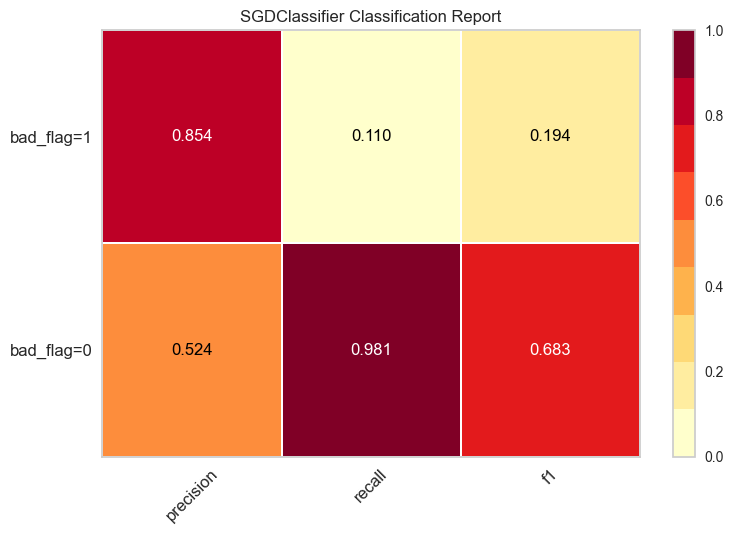

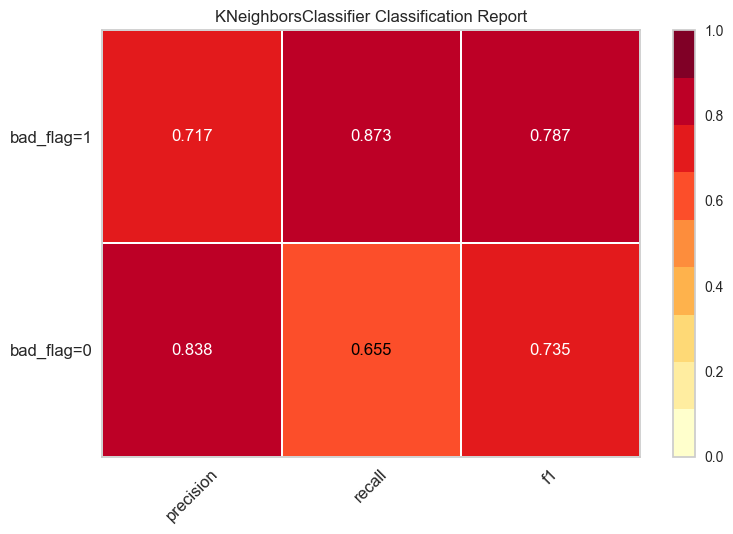

/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


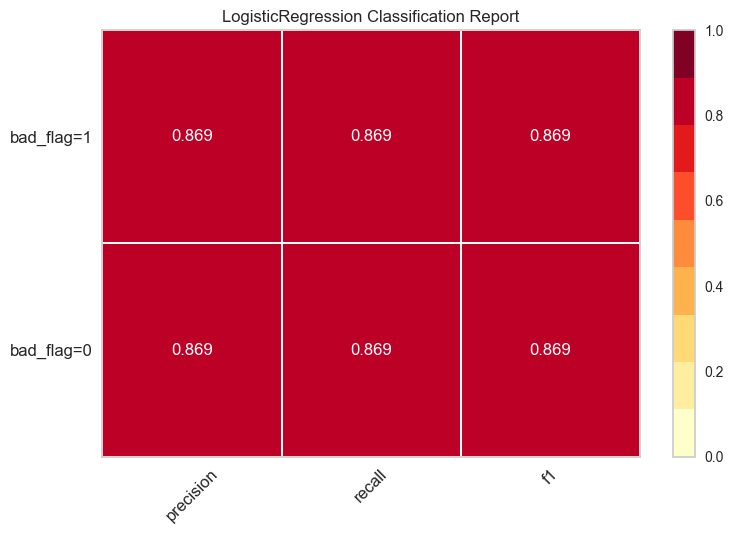

/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chandrasekaransidha/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

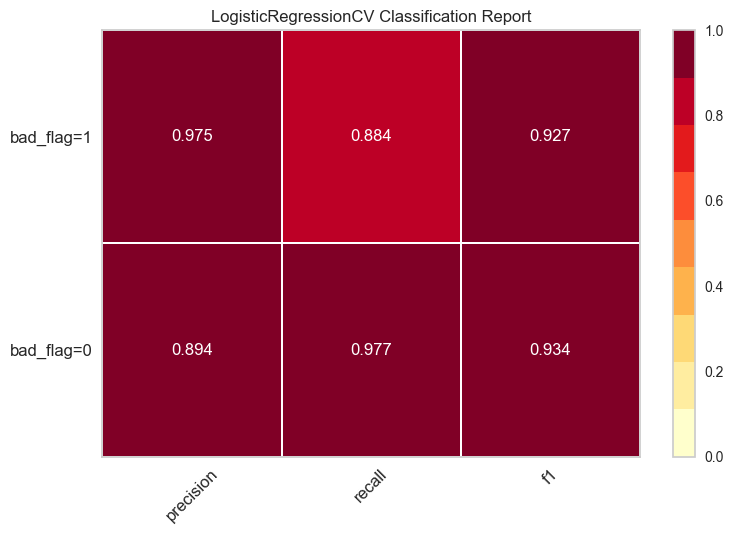

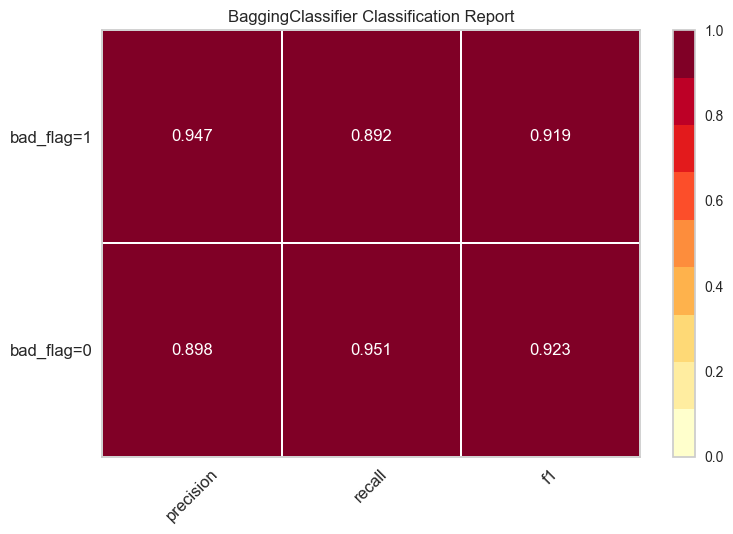

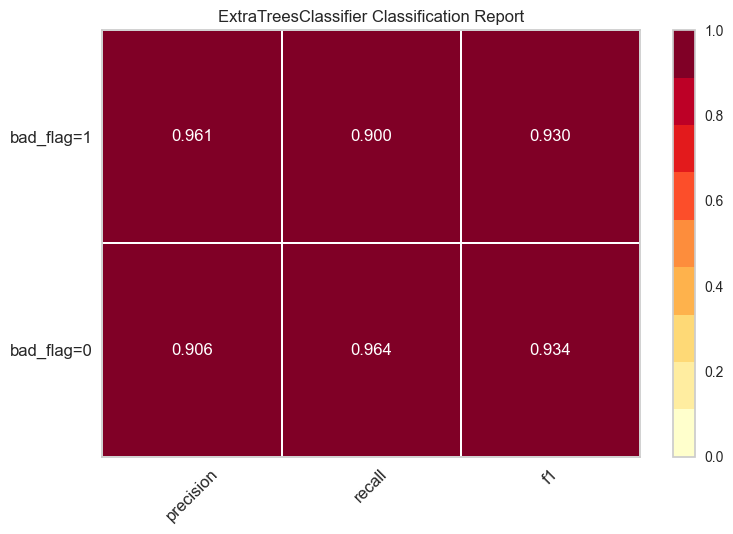

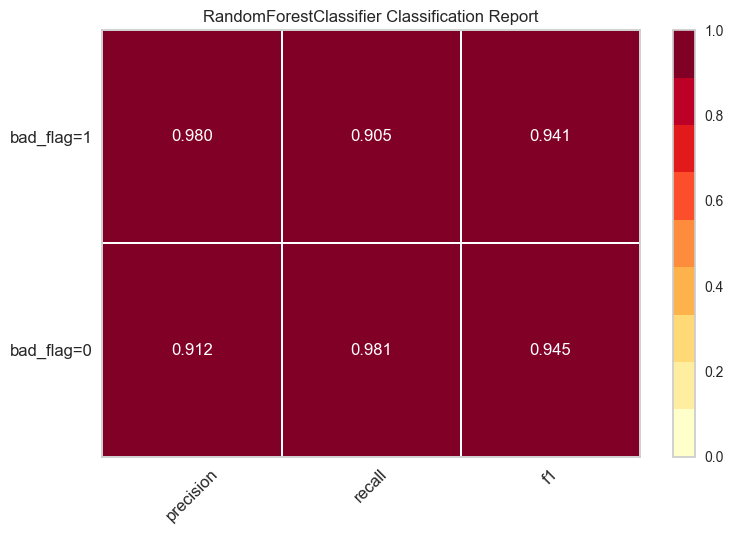

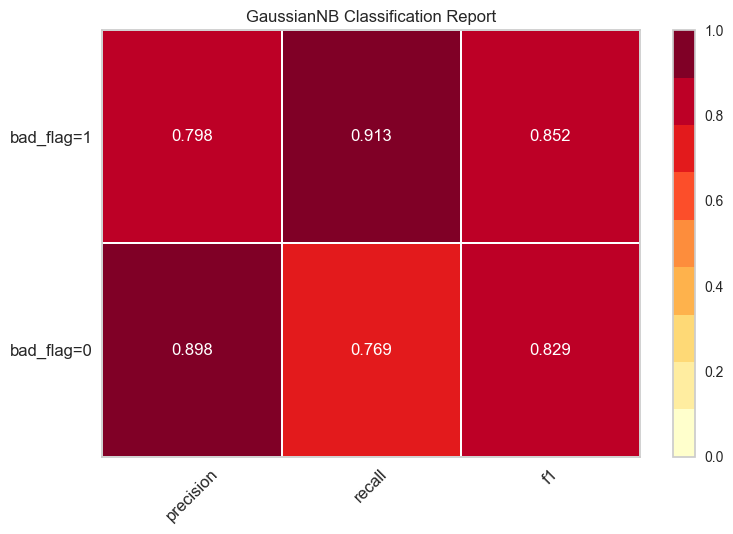

In [128]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(df_loans_x_resampled, df_loans_y_resampled,
                                                    test_size=0.2,
                                                    stratify=df_loans_y_resampled,
                                                    random_state=2)

for classifier in classifiers:
    visualizer = ClassificationReport(classifier, classes=["bad_flag=0", "bad_flag=1"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()